# Mitchell Pudil
# Econ 213R 
# Homework 5: Dimensionality Reduction and Clustering

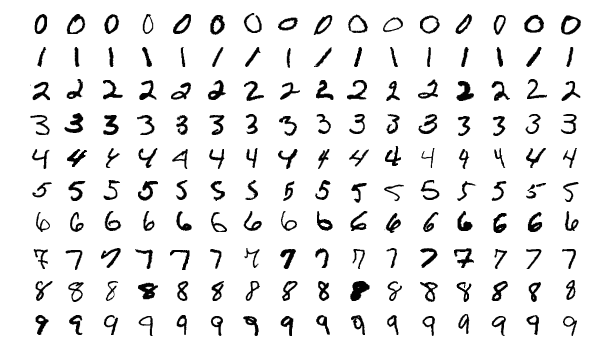

In [1]:
# Source: https://en.wikipedia.org/wiki/MNIST_database
from IPython.display import Image 
Image('https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png')

In [2]:
import sklearn
from sklearn.datasets import fetch_mldata

### About the MNIST data set 

The MNIST data set is hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [3]:
# For some reason, Tyler's code didn't work for me, so I had to download it this way. 
# Credit to Rohith Uppala for helping me out with this.
from six.moves import urllib
from sklearn.datasets import fetch_mldata
from scipy.io import loadmat

mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}

### Separate and scale data

In [4]:
X = mnist['data'] / 255.0
y = mnist['target']

### Import some more packages for data analyzation

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# 1. Use PCA to reduce the dimensionality

### A little about PCA: What it does, its drawbacks, and what it is used for
PCA is common method used to reduce dimensionality while maintaining an appropriate level of variance. It is oftentimes used when there are too many features in a dataset. PCA allows us to reduce overfitting, and speed up computation time. As we continue on, I will point out ways to effectively use PCA. One unfortunate drawback of PCA, however, is that it reduces interpretability of the model because it combines multiple features together.


### We will begin by looking at 2 components, and seeing how that reduces our dimensionality

In [6]:
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X)
X_2dim.shape


(70000, 2)

In [7]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445])

Between our 2 components, it looks like we are explaining about 17% of our data. 

Let's now plot these first two components.

Text(0.5,1,'First Two Components')

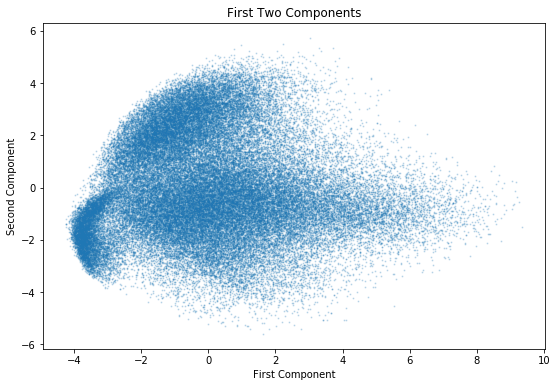

In [8]:
fig = plt.figure(figsize=(9,6))
plt.scatter(X_2dim[:,0], X_2dim[:,1], marker='.', alpha=.2, s = 4)
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('First Two Components')

This plot takes the 784 dimensional dataset we have and compresses it down to just two features. There does not appear to be any prominent relationship or trend between the first two components.

Ideally, we would like to be able to explain 95% of our data. Any less won't give a good estimate. Too much will lead to the curse of dimensionality; that is, when dimensionality increases, the volume of the space increases so fast that the available data become sparse, which can lead to overfitting.

### Let's graph out how the explained ratio changes as we add more principal components.

Text(0.5,1,'Explained Ratio by Number of Components')

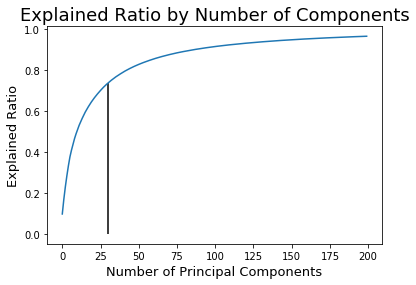

In [9]:
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[30],x=30)
plt.ylabel('Explained Ratio', fontsize=13)
plt.xlabel('Number of Principal Components', fontsize=13)
plt.title('Explained Ratio by Number of Components', fontsize=18)

We notice that after about 30 principal components, the rate at which the explained ratio increases occurs at a much slower rate. However, for the reasons provided above, we still would like to get to the 95% benchmark (although 30 would also be a reasonable number of components to use).

### Let's now look at how many principal components are necessary to get 95% of the variation

In [10]:
index_95 = np.argmax(cum_ratio > 0.95)
print('In order to get 95% variation, you will need to use {} components'.format(index_95))

In order to get 95% variation, you will need to use 153 components


We will therefore use 153 components to reach that 95% variation.

### Now that we have determined how many components we will need to use, let's plot some of the images, then compress them using PCA and plot again. 

In [11]:
pca = PCA(n_components=144)  # Reduce X to 153 dimensions (70,000 x 153) through PCA
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(70000, 144)


Let's begin by plotting the first observation in our data set: the number zero. 

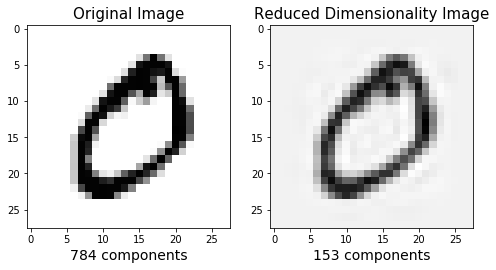

In [12]:
def pca_numbers(row_number):
    plt.figure(figsize=(8,4));
    # Original Image
    plt.subplot(1, 2, 1);
    plt.imshow(mnist['data'][row_number].reshape(28,28),
                  cmap ='Greys', interpolation='nearest',
                  clim=(0, 255));
    plt.xlabel('784 components', fontsize = 14)
    plt.title('Original Image', fontsize = 15);

    # 153 principal components
    pca = PCA(n_components=153)
    X_pca = pca.fit_transform(X)
    X_back_to_normal = pca.inverse_transform(X_pca)

# Plot the same image that has been compressed and then inversed transformed
    plt.subplot(1, 2, 2);
    plt.imshow(X_back_to_normal[row_number].reshape((28,28)), cmap='Greys');
    plt.xlabel('153 components', fontsize = 14)
    plt.title('Reduced Dimensionality Image', fontsize = 15);

pca_numbers(0)

### Let's now plot a couple more numbers to help us get a better idea of how sufficient 153 components (about 1/5 of the original number of components) is.

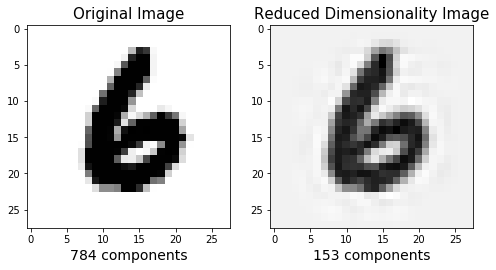

In [13]:
pca_numbers(40200)  # The number 6

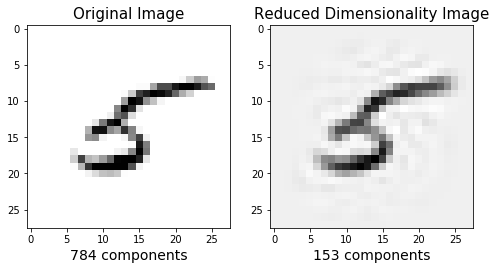

In [14]:
pca_numbers(66000)  # Number 5

It appears that 153 components is sufficient to capture 95% of the variation in the images. The images seem nearly identical.

# 2. Use t-SNE to plot the first two components

According to Tyler Folkman, t-SNE has become pretty popular. It is a dimensionality reduction technique, but it is mostly used for visualization and not data pre-processing. For this reason, you almost always reduce the dimensionality down to 2 with t-SNE, so that you can then plot the data in two dimensions.

Let's begin this process by downloading TSNE from sklearn.

In [15]:
from sklearn.manifold import TSNE  

Trial 1: perplexity of 50, learning rate of 200, 1000 iterations

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.051s...
[t-SNE] Computed neighbors for 10000 samples in 38.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.170032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.534752
[t-SNE] KL divergence after 1000 iterations: 1.719114


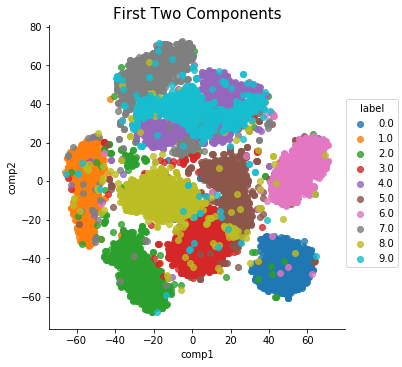

In [16]:
#first reduce dimensionality before feeding to t-sne
def reduce_dim(perplex, learn_rate, iterations):
    pca = PCA(n_components=153)
    X_pca = pca.fit_transform(X)

    # Sample 10,000 rows
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    tsne = TSNE(n_components=2, verbose=1, perplexity=perplex, n_iter=iterations, learning_rate=learn_rate)
    tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])
    
    # Plot results
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows[:n_select]]
    
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    ax = plt.gca() # Add a title
    ax.set_title("First Two Components", fontsize=15)

reduce_dim(50,200,1000)

## t-SNE vs PCA
PCA allowed us to see a visual example of what the machine was "reading" and how reducing the dimensionality affected the visual components of the numbers. However, the t-SNE plot uses clusters to explain the areas in which the machine is getting "confused" and where and how it predicts incorrectly (and the areas in which it does well). For example, we notice that it is good at figuring out if a number is a 2 or not, but it can oftentimes confuse a 7 with a 9, or a 4 with a 9. 

In order to answer parts b and c, we will change the perplexity, learning rate, and number of iterations. We will begin by changing the perplexity

## Changes in perplexity

Let's first decrease the perplexity to 5

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 31.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.298311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.723083
[t-SNE] KL divergence after 1000 iterations: 1.968032


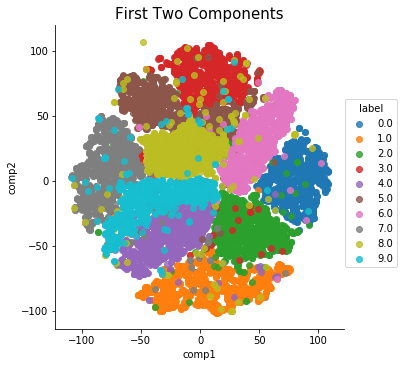

In [17]:
reduce_dim(5,200,1000)

Increase perplexity to 20

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.061s...
[t-SNE] Computed neighbors for 10000 samples in 39.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.830846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.809288
[t-SNE] KL divergence after 1000 iterations: 1.876905


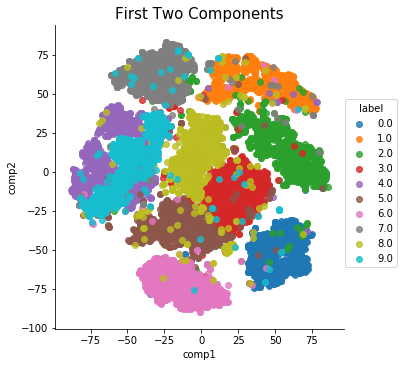

In [18]:
reduce_dim(20,200,1000)

Increase perplexity even more to 100

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 36.881s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.403098
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.705620
[t-SNE] KL divergence after 1000 iterations: 1.550845


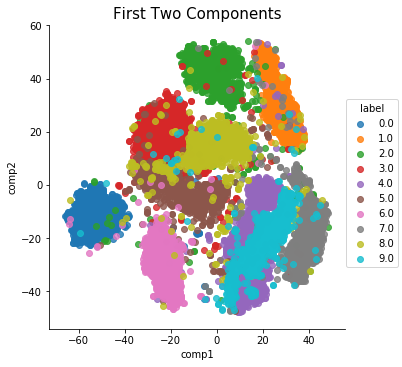

In [19]:
reduce_dim(100,200,1000)

So, is the cluster robust to perplexity? It doesn't appear to be. When we decrease the perplexity to 5, the machine is mixing up similar numbers, but the shape is more circular and the numbers are at different points in the graph. When we increase the perplexity to 20, we get a more similar shape to the graph we got in 50 with different positions of the clusters. Note that perplexity balance attention between the local and global aspects of the dataset. Generally, when we increase perplexity, the clusters are a bit more spread out. This is especially evident when we increase the perplexity to 100.

## Learning Rate and Number of Iterations

Let's now change the learning rate, moving perplexity back to its original level of 50. We will start by decreasing learning rate to 50.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 35.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.145584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.086380
[t-SNE] KL divergence after 1000 iterations: 1.817125


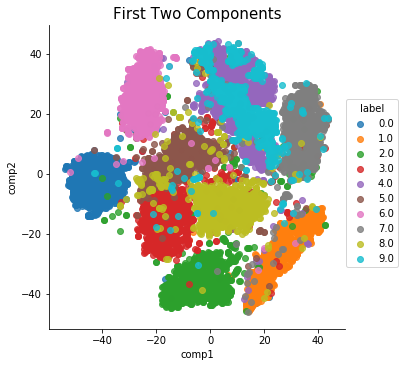

In [20]:
reduce_dim(50,50,1000)

Increase learning rate to 100

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.068s...
[t-SNE] Computed neighbors for 10000 samples in 37.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.145661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.777824
[t-SNE] KL divergence after 1000 iterations: 1.749552


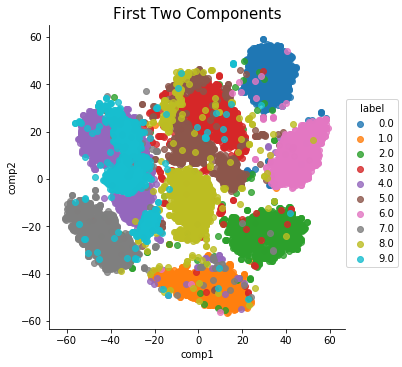

In [21]:
reduce_dim(50,100,1000)

Increase learning rate to 400

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.075s...
[t-SNE] Computed neighbors for 10000 samples in 40.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.163628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.380455
[t-SNE] KL divergence after 1000 iterations: 1.709500


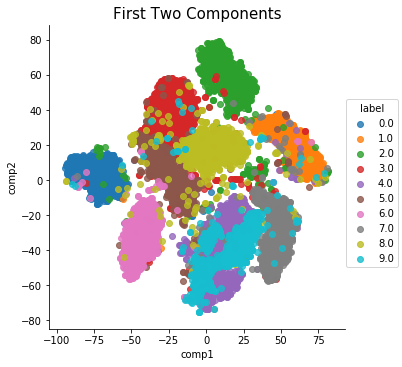

In [22]:
reduce_dim(50,400,1000)

Is the clustering robust to learning rate? A bit, but not really any more than perplexity was. It didn't drastically change the overall performance of the clustering, mainly just the shape and positions of the cluster, but even that didn't change too terribly much (at least to a point). 

Let's now change the number of iterations.
Decrease number of iterations to 250

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.056s...
[t-SNE] Computed neighbors for 10000 samples in 38.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.152113
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.860062
[t-SNE] KL divergence after 251 iterations: 179769313486231570814527423731704

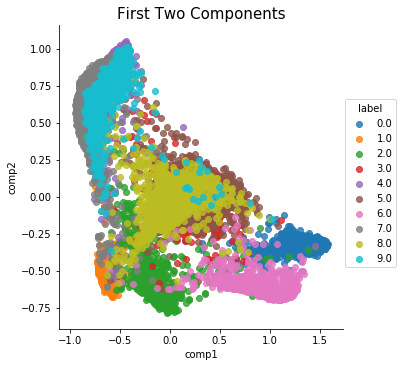

In [23]:
reduce_dim(50,200,250)

Increase number of iterations to 500

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.051s...
[t-SNE] Computed neighbors for 10000 samples in 35.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.168302
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.221397
[t-SNE] KL divergence after 500 iterations: 1.911430


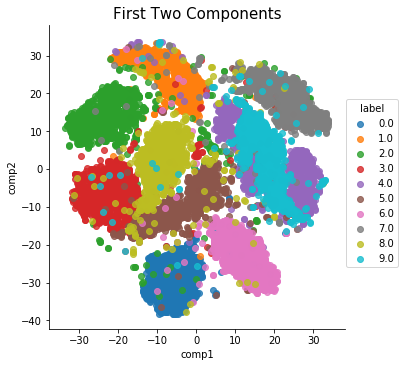

In [24]:
reduce_dim(50,200,500)

Increase number of iterations to 2000

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 36.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.151362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.278397
[t-SNE] KL divergence after 2000 iterations: 1.683332


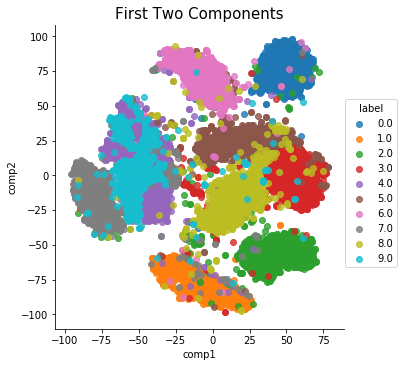

In [25]:
reduce_dim(50,500,2000)

It appears that changing the number of iterations is even less robust than changing the perplexity or learning rate. This is especially evident when we only have 250 iterations. With 250 iterations, it appeared that the clusters were on top of each other.

# 3. Perform k-means clustering

The goal of clustering is to discover groups of data within our data where observations within a group are similar to each other and different from other groups. K-means clustering uses a hyperparameter K, defined as the number of distinct clusters in a set of data, by using the features of the given data. Let's apply this now to our data set.

In [26]:
from sklearn.cluster import KMeans # import K Means
from sklearn import preprocessing

### Scale the data

In [27]:
# Scale the data
X_scaled = preprocessing.scale(X)

# Take sample of the data
X_scaled = shuffle(X_scaled)[0:4000]

# Take the first two components
pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X_scaled)

# Create Pandas Data Frame
df_scaled = pd.DataFrame({'comp1':X_2dim[:,0], 'comp2':X_2dim[:,1]})

### We will use the elbow method to determine a reasonable value for K
The idea behind this is the same as diminishing marginal returns: after a while, it becomes unnecessary and even bad to increase k too much. If it is too small, we run the risk of high variance. If it is too low, we run the risk of overfitting.

Text(0,0.5,'Sum of Squared Distances')

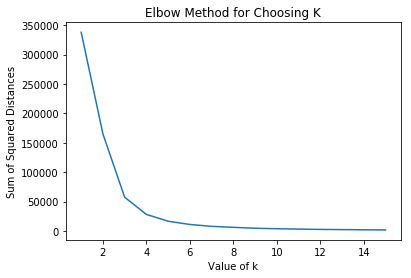

In [28]:
sses = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(df_scaled[['comp1', 'comp2']])
    sses.append(kmeans.inertia_)
plt.plot(range(1,16), sses)
plt.title('Elbow Method for Choosing K')
plt.xlabel('Value of k')
plt.ylabel('Sum of Squared Distances')

Here it looks like maybe the elbow in the graph is around 5 clusters for our data, so with this method that would be the value of k we would choose. Obviously, this is heuristic and far from scientific. It is also important to note that the sum of the squared distances will always decrease as k increases.

### Evaluating the cluster

We will now evaluate the cluster. Now, many different types of clusters assume knowledge of the ground truth, which make them less valuable. When no ground truth is known, a metric like the Silhouette Coefficient can be useful. This coefficient is the mean distance between a sample and all other points in the next nearest cluste subtracted by the mean distance between a sample and all other points in the same class. The score is better when higher and ranges from -1 to 1. A higher score means the clusters are dense and well seperated. Source: Tyler Folkman

The following function will take in the number of desired clusters and iterations as arguments, and then perform K Means to produce a visualization of the clustering and determine the Silhouette score.

We have a Silhouette Score of 0.505, so our model is doing pretty good, but it is not perfect.


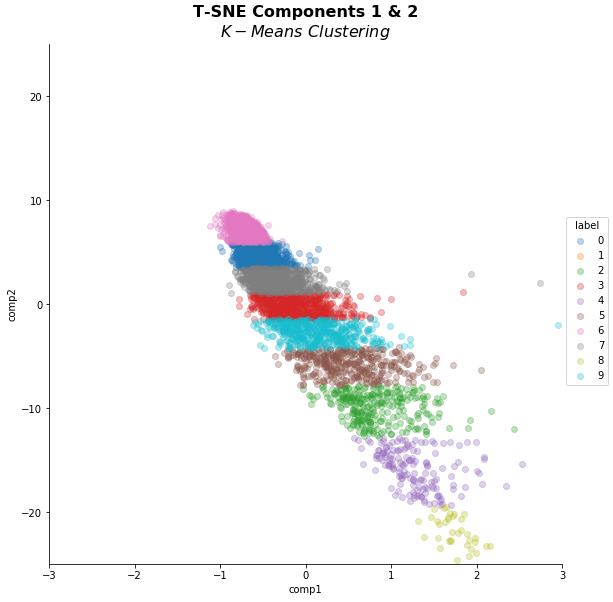

In [42]:
from sklearn.metrics import silhouette_score
def kmeans_tsne(clusters, iterations):
    kmeans_model = KMeans(n_clusters=clusters, n_init=iterations, n_jobs=-1).fit(df_scaled[['comp1', 'comp2']])
    labels = kmeans_model.labels_
    score = round(silhouette_score(df_scaled[['comp1', 'comp2']], labels, metric='euclidean'),3)
    print('We have a Silhouette Score of {}, so our model is doing pretty good, but it is not perfect.'.format(score))
    
    # Visualize clusters using t-SNE
    
    # Create dataframe of results
    df_tsne = pd.DataFrame(df_scaled, columns=['comp1', 'comp2'])
    df_tsne['label'] = labels

    # Create the plot
    lm = sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False, scatter_kws={'alpha':0.3}, size=8)
    plt.title('T-SNE Components 1 & 2\n$\it{K-Means}$ $\it{Clustering}$', fontsize=16, fontweight='bold')
    axes = lm.axes
    axes[0,0].set_ylim(-25,25)
    axes[0,0].set_xlim(-3,3)
kmeans_tsne(10,50)

### Determine robustness of the clustering
We will now determine the robustness of the clustering by changing the number of iterations

We have a Silhouette Score of 0.505, so our model is doing pretty good, but it is not perfect.


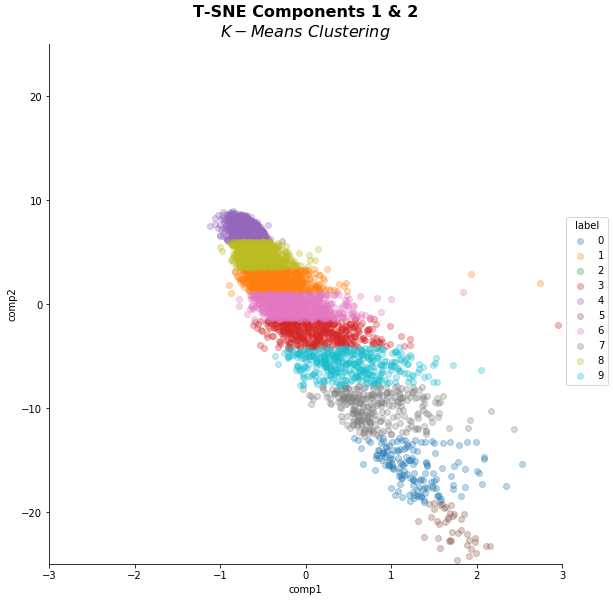

In [44]:
kmeans_tsne(10,100)

It appears that the clustering is decently robust, at least up to a certain point. We can see this because when we decreased the number of iterations from 50 to 20, the graphs looked about the same (note this does not mean this will occur for any arbitrary number of iterations).

Just for fun, let's now change the number of clusters and see what happens.

We have a Silhouette Score of 0.513, so our model is doing pretty good, but it is not perfect.


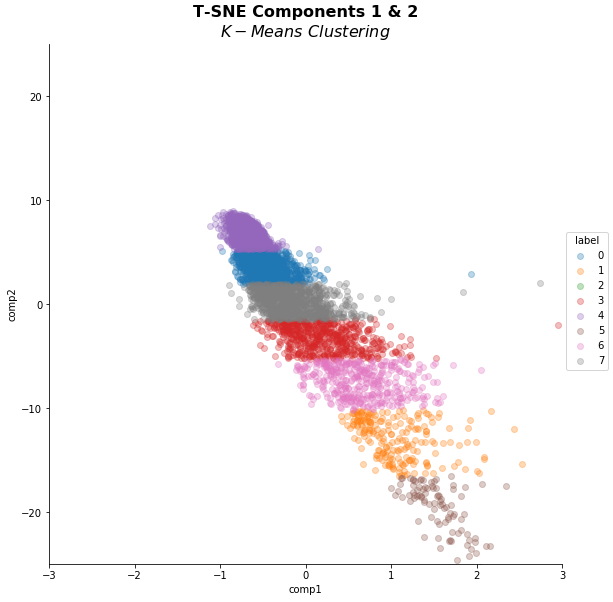

In [45]:
kmeans_tsne(8,50)

The clusters changed in a pretty reasonable way. In practice, it's important to use intuition as well as the graph itself to determine how many clusters to have, or even how many iterations to perform.

# 4. Hierarchical clustering

Hierarchical clustering is another type of clustering that doesn't require us to provide a value for k. However, since we do have a very large number of observations, we will shuffle and only use the first 1000 observations. We will start off by using the "complete" link method, which 


In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage  # Import necessary packages for linking


The following function will take in the link method as the argument and plot the dendogram.

In [33]:
def plot_dendogram(link_method):
    X_shuffled = shuffle(X)
    Z = linkage(X_shuffled[0:100], link_method)
    plt.figure(figsize=(20, 10))
    _ = dendrogram(Z)

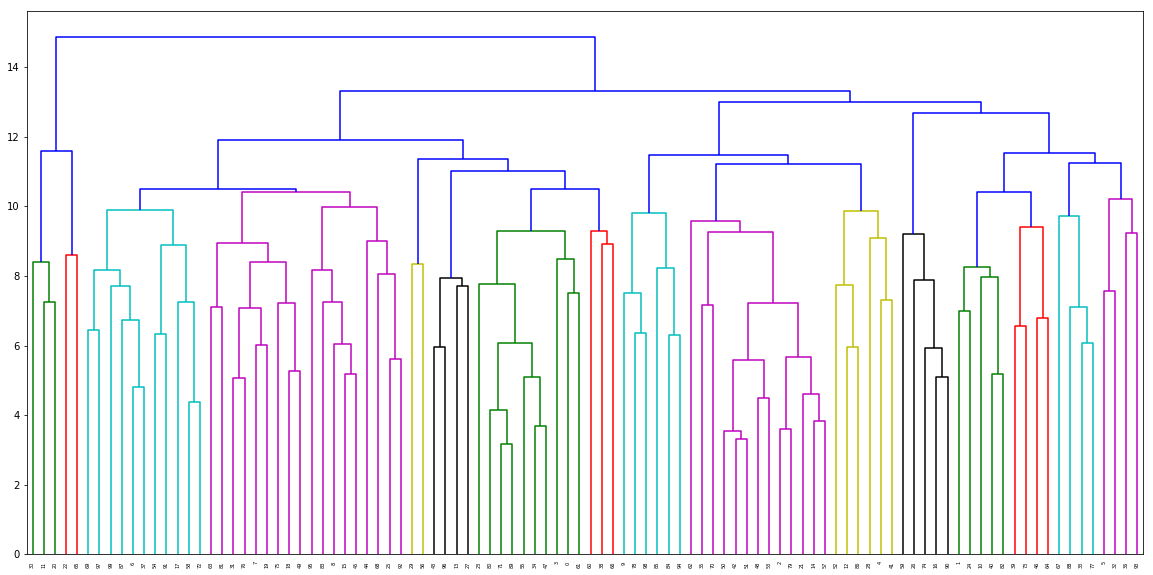

In [35]:
plot_dendogram('complete')

So, how do we choose the number of clusters we want from agglomerative clustering? Simple - you draw a horizontal line at they y-axis value you think is reasonable for the problem and the number of vertical lines it crosses is the number of clusters you get - where the distinct sets beneath the line are your clusters. In this case, we have 10 numbers, so 10 clusters would be best. This would imply that our horizontal line cutoff would be at about y=11. 

Let's now explore how the dendogram changes with different linking methods. We will use the following methods:

Complete - Use the maximum distance between points in clusters (already done above)
Ward - Merge the two clusters which minimize the total within-cluster variance after merging 
Average - Use the average distance between points in clusters

We will now use the complete ward method.

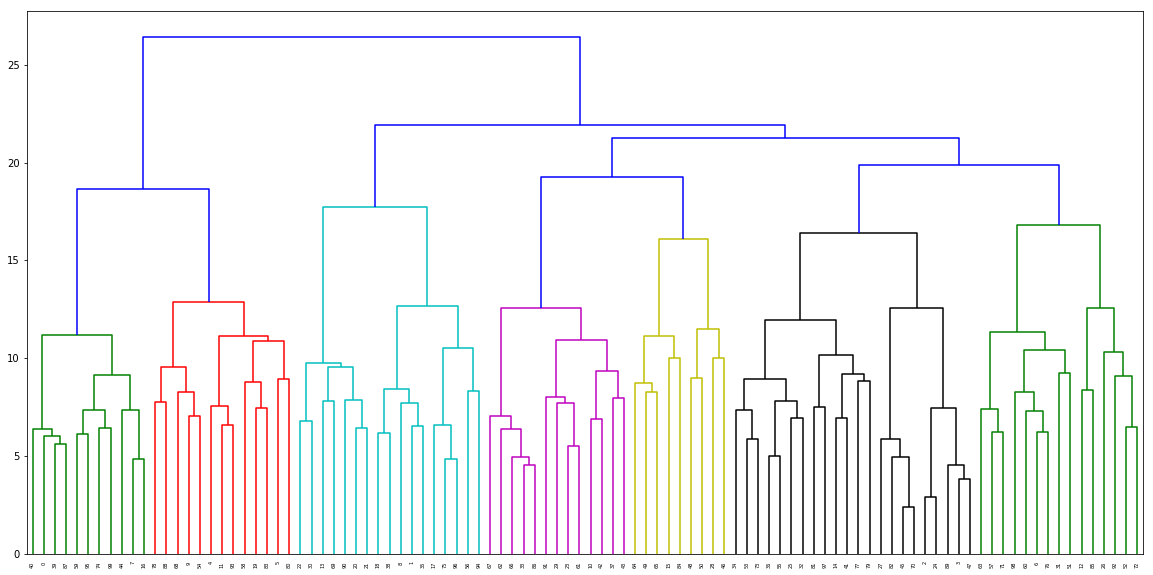

In [34]:
plot_dendogram('ward')

Now we will take a look at the average link method

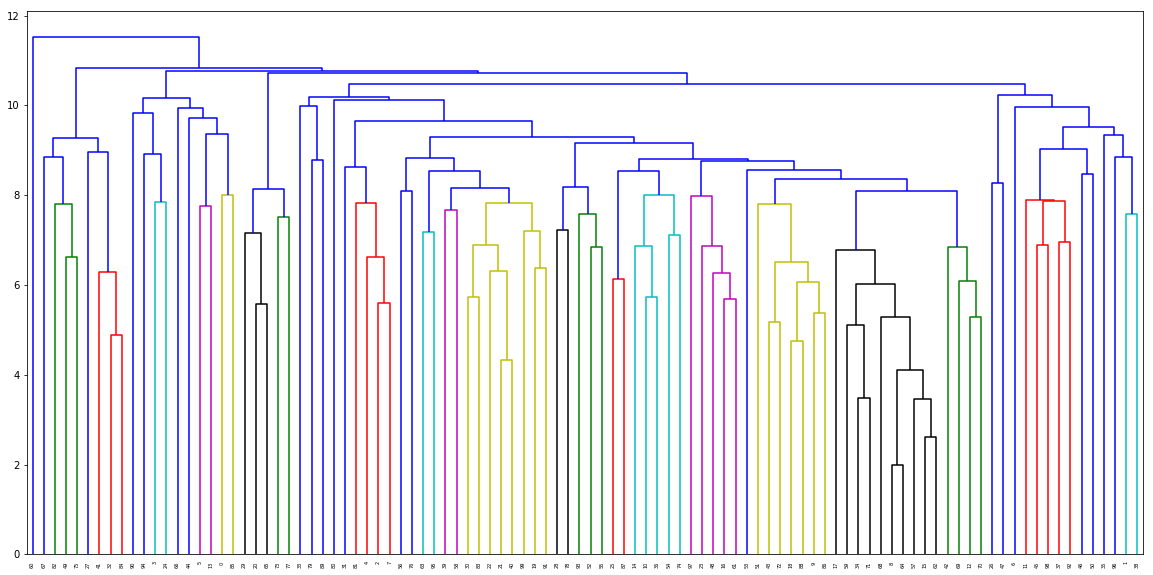

In [36]:
plot_dendogram('average')

It appears that the "complete" and "ward" linking method work the best to most clearly define the 10 clusters. The "average" link method is a bit messier, and is harder to find exactly where we could set the horizontal line.

Well, there we go! We have now used a few different methods: PCA, t-SNE, K Means, and Hierarchical Clustering to analyze this data set and determine the best methods of clustering.